<h1>
    <center>
    TMA4215 Project 1


### Table of contents
#### 1. Introduction
#### 2. Algorithm 
#### 3. 

### 1. Introduction

The purpose of this project is to use a neural network to train approximations of Hamiltonian function, derive and implement formulas for computing the gradient of the trained function and use those to implement symplectic Euler and the Størmer-Verlet method for the Hamiltonian function. 

This

### 2. Algorithm

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import isclose
from mpl_toolkits.mplot3d import Axes3D

In [3]:
from project_2_data_acquisition import generate_data, concatenate
from files import writeParams, readParams

The functions above are imported from separate files and are used to generate input data batches from comma seperated files and to write our trained values to a file as well as reading these values from a file. 

The algorithm is divided into several smaller codeblocks with the purpose of making the code easy to follow. Principally, the algorithm's parts is to transform input data between the layers in the network, decide the gradients of the objective function, $J = \frac{1}{2} \|Z-c\| $, with respect to weights, biases, $\omega$ and $\mu$ and optimalize the network with respect to those. Additionally, several utility functions is defined to be used in the algorithm.

In [4]:
def getW(K,d):
    w = np.random.randn(K,d,d)
    return w

def getb(K,d):
    b = np.random.randn(K,d,1)
    return b

def getomega(d):
    omega = np.random.randn(d,1)
    return omega

def getmu():
    mu = np.random.randn(1)
    return mu

The functions above generate random initial values drawn from a standard normal distribution to the weights, $W_k$, the biases, $b_k$, $\omega$ and $\mu$. These random values causes some marginal differences between runs of the same dataset. 

In [5]:
def getZ(Y0, W, b, K, d, I, h, sigma):
    #initialize Z, Z0=Y0
    Z = np.zeros((K,d,I))
    Z[0] = Y0

    #finds Zk
    for k in range(1,K):
        u = W[k-1]@Z[k-1] + b[k-1]
        Z[k] = Z[k-1] + h*sigma(u)

    return Z

def getP(Z, ypsilon, c, omega, mu, W, b, K, d, I, h, sigma_div, eta_div):
    #initialize P
    P = np.zeros((K+1,d,I))

    #finds P_K
    u = np.transpose(Z[-1])@omega + mu
    P[-1]= omega@np.transpose((ypsilon-c)*eta_div(u))

    #finds P_K-1 to P_0
    for k in range(K-1,0,-1):
        s = W[k]@Z[k] + b[k]
        P[k]=P[k+1] + h*np.transpose(W[k])@(sigma_div(s)*P[k+1])
        
    return P


def getYpsilon(Z, omega, mu, K, eta):
    u = np.transpose(Z[K-1]) @ omega + mu
    return eta(u)

def getJ(ypsilon, c):
    return 1/2 * np.linalg.norm(ypsilon-c)**2

In [7]:
def getMandV(theta):
    return np.zeros_like(theta),np.zeros_like(theta)

def adam(m,v,g,i):
    #parameters
    beta1 = 0.9
    beta2 = 0.999
    alpha = 0.01
    epsilon = 10E-8

    #m,v
    m = beta1*m + (1-beta1)*g
    v = beta2*v + (1-beta2)*np.multiply(g,g)

    m_hat = np.multiply(m,1/(1-beta1**i))
    v_hat = np.multiply(v,1/(1-beta2**i))

    #update
    R = alpha*np.multiply(m_hat,1/(np.sqrt(v_hat)+epsilon))

    return m,v,R

In [8]:
def eta(x):
    return 1/2*(1+np.tanh(x/2))

def eta_div(x):
    return 1/(4*np.cosh(x/2)**2) 

def sigma(x):
    return np.tanh(x)

def sigma_div(x):
    return 1 - np.tanh(x)**2

Above, the activating function $\sigma$ 

In [9]:
def scale(x, alpha=0.2, beta=0.8):
    a = np.amin(x)
    b = np.amax(x)
    
    x_tilde = 1/(b-a)*((b-x)*alpha + (x-a)*beta)
    return x_tilde, a, b

def inverseScale(x_tilde, a, b, alpha=0.2, beta=0.8):
    return 1/(beta-alpha)*((x_tilde-alpha)*b + (beta-x_tilde)*a)

In [10]:
def successrate(ypsilon, c, tol):
    sum = 0
    for i in range(ypsilon.shape[0]):
        if isclose(ypsilon[i][0], c[0][i], abs_tol = tol):
            sum +=1
    return sum/ypsilon.shape[0]

In [11]:
def trainingAlgorithm(K, d, h, tau, Y0, c0, eta, sigma, eta_div, sigma_div, N, chunksize, optimization):
    #finds input shape
    d0 = Y0.shape[0]
    I0 = Y0.shape[1]
    
    #reshapes input to match dimension of layers
    if d0 > d:
        return "d must be larger than d0"
    
    if d0 < d:
        zero = np.zeros((d-d0,I0))
        Y0 = np.vstack((Y0,zero))
    
    #gets initial weigths
    omega = getomega(d)
    mu = getmu()
    W = getW(K,d)
    b = getb(K,d)
    
    c0 = np.transpose(c0)
  
    if optimization == "adam":
        #initial m,v for adam descent
        mmu,vmu = getMandV(mu)
        momega,vomega =getMandV(omega)
        mW,vW = getMandV(W)
        mb,vb = getMandV(b)
    
    #initializes vector to store objective function values
    J = np.zeros(N)
    
    
    for i in range(N):
        
        #stochastic gradient descent
        if I0 == chunksize:
            Y0_chunk = Y0
            c_chunk = c0
        elif I0 > chunksize:
            s = np.random.randint(0,I0-chunksize)
            Y0_chunk = Y0[:,s:(s+chunksize)]
            c_chunk=c0[s:(s+chunksize),:]
        else:
            return "chunksize must be smaller than I"        
        

        #transformations between layers
        Z = getZ(Y0_chunk, W, b, K, d, chunksize, h, sigma)
        ypsilon = getYpsilon(Z, omega, mu, K, eta)
        P = getP(Z, ypsilon, c_chunk, omega, mu, W, b, K, d, chunksize, h, sigma_div, eta_div)
        
        #objective function
        J[i] = getJ(ypsilon, c_chunk)
        
        #finds gradients
        dJdmu = getdJdmu(Z, ypsilon, c_chunk, omega, mu, K, eta_div)
        dJdomega = getdJdomega(Z, ypsilon, c_chunk, omega, mu, K, eta_div)
        dJdW = getdJdW(P, Z, W, b, K, h, sigma_div)
        dJdb = getdJdb(P, Z, W, b, K, h, sigma_div)
        
        if optimization == "plain":
            mu = mu - tau*dJdmu
            omega = omega - tau*dJdomega
            W = W - tau*dJdW
            b = b - tau*dJdb
        
        elif optimization == "adam":
            mmu,vmu, Rmu = adam(mmu,vmu,dJdmu,i+1)
            momega,vomega, Romega = adam(momega,vomega,dJdomega,i+1)
            mW,vW, RW = adam(mW,vW,dJdW,i+1)
            mb,vb, Rb = adam(mb,vb,dJdb,i+1)

            #updates weights and biases
            mu = mu-Rmu
            omega = omega - Romega
            W = W - RW
            b = b - Rb
        
    return mu, omega, W, b, J, ypsilon

In [12]:
def testing(yTest, cTest, W, b, omega, mu, K, d, I, h, sigma, eta):

    #scaling of input
    yTilde, aY, bY = scale(yTest)
    cTilde, ac, bc = scale(cTest)

    #finds input shape
    d0 = yTest.shape[0]
    
    if d > d0:
        zero = np.zeros((d-d0,I))
        yTilde = np.vstack((yTilde,zero))
    
    zTest = getZ(yTilde, W, b, K, d, I, h, sigma)
    ypsilonTilde = getYpsilon(zTest, omega, mu, K, eta)

    #rescaling of input
    ypsilonTest = inverseScale(ypsilonTilde, ac, bc)

    return ypsilonTest

### 3. Testing with suggested functions

#### 3.1  F

In [13]:
#defines global variables
h = 0.1      #stepsize
tau = 0.01   #learning parameter

In [14]:
def F(y):
    return 1-np.cos(y)

In [15]:
N_F = 2500     #number of training series
K_F = 100      #number of hidden layers
d_F = 2      #dimension of layers for F(y)
I_F = 100      #input size 

#training with F(y)
Y0_F = np.linspace(-2,2,I_F)
Y0_F.resize(1,I_F)
c_F = F(Y0_F)

Y0_F_tilde, aY0_F, bY0_F = scale(Y0_F)
c_F_tilde, ac_F, bc_F = scale(c_F)

mu_F, omega_F, W_F, b_F, J_F, ypsilon_F = trainingAlgorithm(K_F, d_F, h, tau, Y0_F_tilde, c_F_tilde, eta, sigma, eta_div, sigma_div, N_F, I_F, "adam")

In [ ]:
writeParams(W_F, b_F, omega_F, mu_F,ypsilon_F, filename = 'trainingParams_F.txt')

In [ ]:
W_Fr,b_Fr,omega_Fr,mu_Fr,ypsilon_Fr = readParams(K_F, d_F, I_F, filename='trainingParams_F.txt')

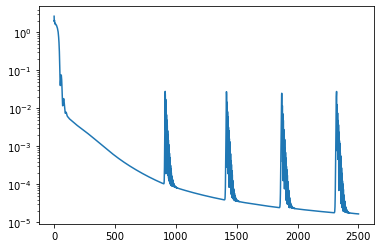

In [16]:
plt.plot(np.linspace(0,N_F,N_F), J_F)
plt.yscale('log')
plt.show()

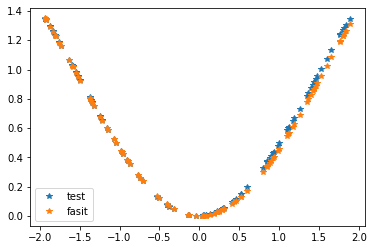

In [17]:
#testing with F(y)
YTest_F = np.random.uniform(-2,2,(1,I_F))
cTest_F = F(YTest_F)


ypsilonTest_F = testing(YTest_F, cTest_F, W_F, b_F, omega_F, mu_F, K_F, d_F, I_F, h, sigma, eta)

plt.figure()
plt.plot(YTest_F[0], ypsilonTest_F, "*", label = "test")
plt.plot(YTest_F[0], cTest_F[0], "*", label = "fasit")
plt.legend()
plt.show()

#### 3.2 G

In [18]:
def G(y1, y2):
    return 1/2 *(y1**2 + y2**2)

In [19]:
N_G = 2500     #number of training series
K_G = 100      #number of hidden layers
d_G = 4      #dimension of layers for F(y)
I_G = 100      #input size 

#training with G(y)
Y0_G = np.random.uniform(-2,2,(2,I_G))
c_G = G(Y0_G[0],Y0_G[1])
c_G.resize(1,I_G)

Y0_G_tilde, aY0_G, bY0_G = scale(Y0_G)
c_G_tilde, ac_G, bc_G = scale(c_G)

mu_G, omega_G, W_G, b_G, J_G, ypsilon_G = trainingAlgorithm(K_G, d_G, h, tau, Y0_G_tilde, c_G_tilde, eta, sigma, eta_div, sigma_div, N_G, I_G, "adam")

In [ ]:
writeParams(W_G, b_G, omega_G, mu_G, ypsilon_G, filename = 'trainingParams_G.txt')

In [ ]:
W_Gr,b_Gr,omega_Gr,mu_Gr, ypsilon_Gr = readParams(K_G, d_G, I_G, filename='trainingParams_G.txt')

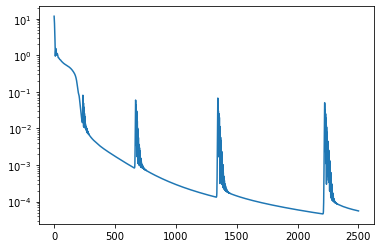

In [20]:
#plotting of objective function
plt.plot(np.linspace(0,N_G,N_G), J_G)
plt.yscale("log")
plt.show()

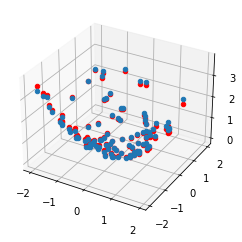

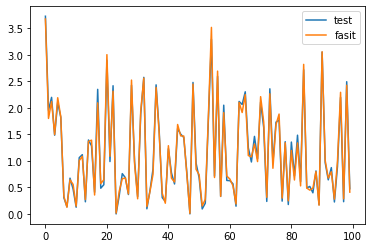

In [21]:
#testing with G(y)
YTest_G = np.random.uniform(-2,2,(2,I_G))
cTest_G = G(YTest_G[0], YTest_G[1])
cTest_G.resize(1,I_G)

ypsilonTest_G = testing(YTest_G, cTest_G, W_G, b_G, omega_G, mu_G, K_G, d_G, I_G, h, sigma, eta)


#plotting of G(y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(YTest_G[0], YTest_G[1], ypsilonTest_G, label = "test", depthshade = False)
ax.scatter(YTest_G[0], YTest_G[1], cTest_G[0], label = "test" , c="red", depthshade = False)
plt.show()

x = np.arange(0, I_G)
plt.plot(x, ypsilonTest_G, label ="test")
plt.plot(x, cTest_G[0], label = "fasit")
plt.legend()
plt.show()

### 4. Training with data given

In [32]:
d_0 = 3
N_0 = 3000
K_0= 50


batch0 = generate_data()

p0_tilde, ap0,bp0 = scale(batch0['P'])
T0_tilde, aT0, bT0 = scale(batch0['T'])
T0_tilde.resize(1,T0_tilde.shape[0])

I_0 = p0_tilde.shape[1]

mu_0, omega_0, W_0, b_0, J_0, ypsilon_0 = trainingAlgorithm(K_0, d_0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N_0,500, "adam")

In [ ]:
writeParams(W_0, b_0, omega_0, mu_0, ypsilon_0, filename = 'trainingParams_0.txt')

In [ ]:
W_0r,b_0r,omega_0r,mu_0r,ypsilon_0r = readParams(K_0, d_0, I_0, filename='trainingParams_0.txt')

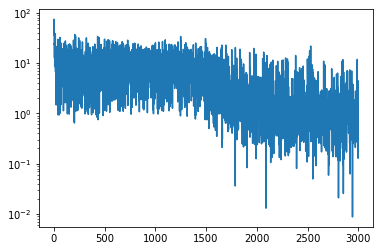

In [34]:
#plotting of objective function
plt.plot(np.linspace(0,N_0,N_0), J_0)
plt.yscale("log")
plt.show()

In [ ]:
x = np.arange(0, I_0)
ypsilon0_scaled = inverseScale(ypsilon_0, aT0, bT0)
T0 = batch0['T']

print(successrate(ypsilon0_scaled, T0, 0.0035))

plt.plot(x, ypsilon0_scaled, label ="test")
plt.plot(x, T0[0], label = "fasit")
plt.legend()
plt.show()

In [26]:
#testing with batch 1

batch1 = generate_data(1)

p1 = batch1['P']
T1 =batch1['T']
T1.resize(1,T1.shape[0])


ypsilonTest_1 = testing(p1, T1, W_0, b_0, omega_0, mu_0, K_0, d_0, I_0, h, sigma, eta)



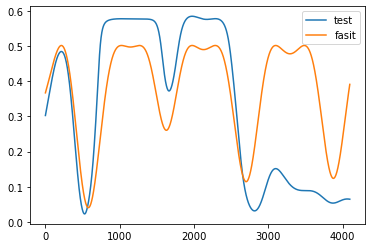

In [29]:
x = np.arange(0, I_0)
plt.plot(x, ypsilonTest_1, label ="test")
plt.plot(x, T1[0], label = "fasit")
plt.legend()
plt.show()